In [1]:
import os, glob 
import cv2 as cv
import numpy as np 
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from seaborn import heatmap, color_palette
from sklearn.metrics import confusion_matrix, classification_report 

In [2]:
#specify data folder
parkinson_dataset_dir = 'data/'

#get a image shape 
image_path = os.path.join(parkinson_dataset_dir, 'normal/ep2d_diff_3scan_trace_p2_ADC_DFC_001.png')

# Open the image
image = Image.open(image_path)

# Get the current size
width, height = image.size

# Print the size
print("Width:", width)
print("Height:", height)



Width: 192
Height: 192


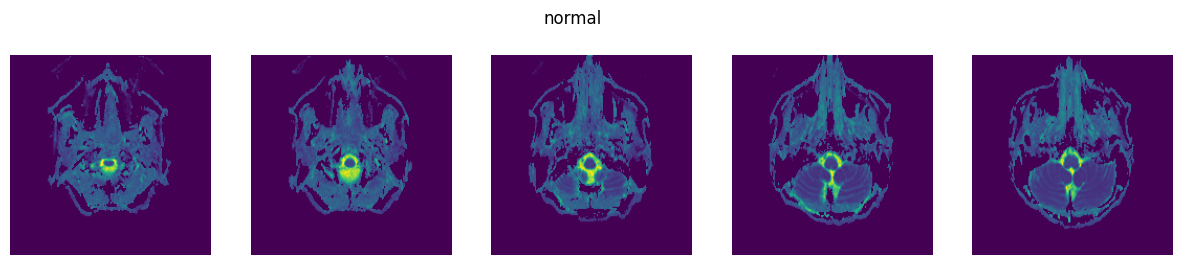

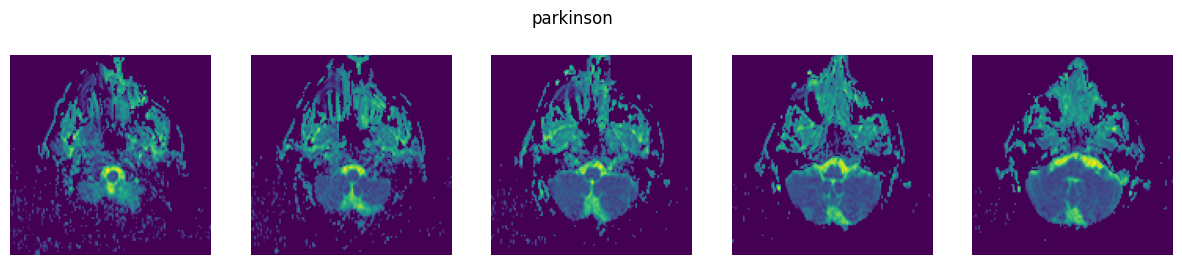

In [3]:
# Function to plot images from a directory with subfolder name
def plot_images_from_directory(directory, label):
    files = os.listdir(directory)[:5]  # Get the first 5 files in the directory
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Create subplots for each image

    for i, file in enumerate(files):
        image_path = os.path.join(directory, file)
        image = Image.open(image_path)

        axes[i].imshow(image)
        axes[i].axis('off')

    plt.suptitle(f"{label}")
    plt.show()

# Iterate over subfolders in the data directory
for folder in os.listdir(parkinson_dataset_dir):
    folder_path = os.path.join(parkinson_dataset_dir, folder)
    if os.path.isdir(folder_path):
        plot_images_from_directory(folder_path, folder)


In [4]:
#specify the target width and height
width = 224
height = 224

target_size = (width, height)

#specify the input shape
input_shape = (width, height, 3) 

In [5]:
#preprocesssing 

def preprocessing_function(img):

    # preprocess the input image according to the preprocessing steps recommended for the Xception model
    img = tf.keras.applications.xception.preprocess_input(img)
    return img


def image_data_generator():

    #DataAugmentation
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                    rotation_range = 30,
                                                                    shear_range = 0.3,
                                                                    zoom_range = 0.3,
                                                                    width_shift_range=0.3,
                                                                    height_shift_range=0.3,
                                                                    horizontal_flip = True,
                                                                    validation_split= 0.15,
                                                                    preprocessing_function=preprocessing_function
                                                                    )
    #Load train data with applying transformations
    train_generator = train_datagen.flow_from_directory(
                                                        parkinson_dataset_dir,
                                                        target_size = target_size,
                                                        color_mode = 'rgb',
                                                        batch_size = 16, #The number of images to include in each batch during training
                                                        class_mode = 'binary',
                                                        subset = 'training',
                                                        shuffle = True # images will be randomly shuffled during training
                                                        )
    
    #Load test data with applying transformations
    validation_generator = train_datagen.flow_from_directory(
                                    parkinson_dataset_dir,
                                    target_size = target_size,
                                    color_mode = 'rgb',
                                    batch_size = 8,
                                    class_mode = 'binary',
                                    subset = 'validation',
                                    shuffle = True
                                    )

    return train_generator, validation_generator

In [6]:
train_generator, validation_generator = image_data_generator()

Found 712 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [7]:
def parkinson_detector():    

    #creates an instance of the Xception model 
    functional_model = tf.keras.applications.Xception(
                                                     weights="imagenet", #model will be initialized with pre-trained weights on the ImageNet dataset
                                                     include_top=False 
                                                     )
    functional_model.trainable = False
    
    #creates an input layer for the model
    inputs = tf.keras.Input(shape=input_shape)

    #connects the input layer inputs to the Xception model functional_model
    x = functional_model(inputs, training=False)

    #Add new layers according to our dataset.Since the Xception has genaralized features

    #reduces the spatial dimensions of the tensor to a vector by taking the average of each channel's values
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # adds a fully connected dense layer with 512 units and a ReLU activation function 
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    return model

In [8]:
model = parkinson_detector()

#compile the model
model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
            loss='binary_crossentropy', 
            metrics=[
                    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall'),
                    tf.keras.metrics.AUC(name='auc')
                    ])

history = model.fit(
                    train_generator,
                    steps_per_epoch = train_generator.samples // train_generator.batch_size,
                    epochs = 20,
                    validation_data = validation_generator,
                    validation_steps = validation_generator.samples // validation_generator.batch_size
                    )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [9]:
#save the model to API calls
#model_version=1

if not os.path.exists('models/parkinson-detector-gnn.h5'):
    model.save("models/parkinson-detector-gnn.h5")

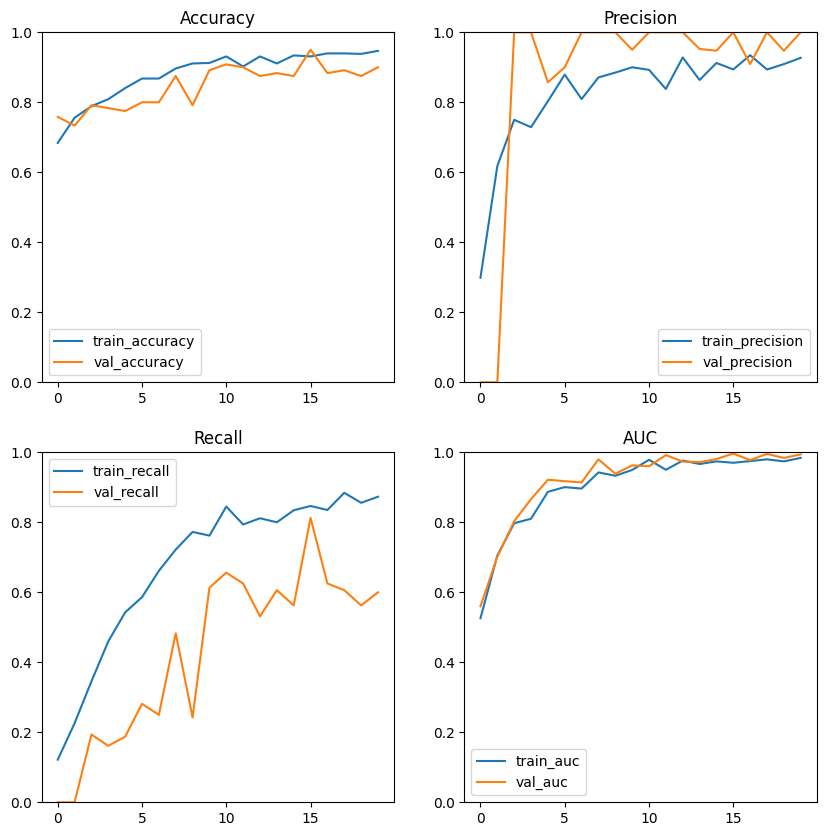

In [10]:
# plot the model
plt.figure(figsize=(10, 10))

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_precision = history.history['precision']
val_precision = history.history['val_precision']

train_recall = history.history['recall']
val_recall = history.history['val_recall']

train_auc = history.history['auc']
val_auc = history.history['val_auc']

plt.subplot(2, 2, 1)
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='val_accuracy')
plt.ylim([0, 1])
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_precision, label='train_precision')
plt.plot(val_precision, label='val_precision')
plt.ylim([0, 1])
plt.title('Precision')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_recall, label='train_recall')
plt.plot(val_recall, label='val_recall')
plt.ylim([0, 1])
plt.title('Recall')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_auc, label='train_auc')
plt.plot(val_auc, label='val_auc')
plt.ylim([0, 1])
plt.title('AUC')
plt.legend()

plt.show()

In [11]:
class_dict = train_generator.class_indices
class_dict_rev = {v: k for k, v in class_dict.items()}
print(class_dict, class_dict_rev)

{'normal': 0, 'parkinson': 1} {0: 'normal', 1: 'parkinson'}


In [12]:
# evaluate the model

def load_dataset():
    all_image_paths = glob.glob(os.path.join(parkinson_dataset_dir, '*/*'))
    all_image_paths = [x.replace('\\', '/') for x in all_image_paths]
    np.random.shuffle(all_image_paths)

    X = np.zeros((len(all_image_paths), width, height, 3), dtype='float32') 
    y = np.zeros(len(all_image_paths), dtype='float32')

    for i, file_path in enumerate(all_image_paths):
        img = cv.imread(file_path)
        img = cv.resize(img, target_size)
        img = preprocessing_function(img)
        X[i] = img

        _, class_folder,_ = file_path.split('/')
        y[i] = class_dict[class_folder]

    return X, y

X, y = load_dataset()

In [13]:
y_pred = model.predict(X)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = y_pred.squeeze()

27/27 [==============================] - 64s 2s/step


In [14]:
# classification report

print("========== Classification Report ==========")
print(classification_report(y, y_pred, target_names=class_dict_rev.values()))

========== Classification Report ==========
              precision    recall  f1-score   support

      normal       0.98      1.00      0.99       610
   parkinson       0.99      0.95      0.97       226

    accuracy                           0.98       836
   macro avg       0.98      0.97      0.98       836
weighted avg       0.98      0.98      0.98       836



========== Confusion Matrix ==========


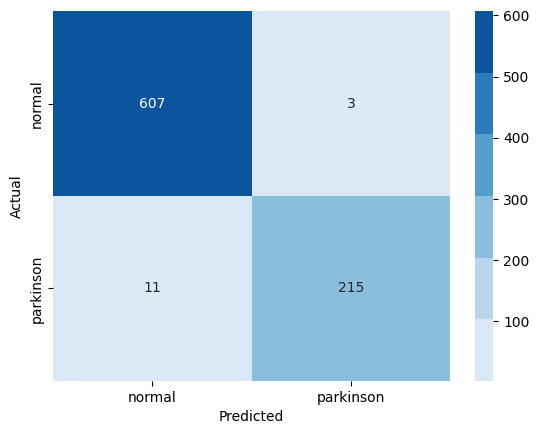

In [15]:
# confusion matrix

print("========== Confusion Matrix ==========")
cm = confusion_matrix(y, y_pred)
class_names = class_dict_rev.values()

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names).astype(int)

heatmap(df_cm, annot=True, fmt="d", cmap=color_palette("Blues"))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



# Testing

In [16]:
loaded_model = tf.keras.models.load_model('models/parkinson-detector-gnn.h5')

In [17]:
class_dict = train_generator.class_indices
class_dict_rev = {v: k for k, v in class_dict.items()}
print(class_dict, class_dict_rev)

{'normal': 0, 'parkinson': 1} {0: 'normal', 1: 'parkinson'}


In [18]:
def inference_model(img_path):
    img = cv.imread(img_path)
    img = cv.resize(img, target_size)
    img = preprocessing_function(img)
    img = np.expand_dims(img, axis=0)

    pred = loaded_model.predict(img)
    pred = pred.squeeze() > 0.5
    pred = pred.squeeze()
    return class_dict_rev[pred]

In [19]:
inference_model('data/parkinson/sDW_SSh_031.png')

1/1 [==============================] - 1s 804ms/step


'parkinson'